### Grad-CAM for visual language tasks

This is an example of Grad-CAM on vision language tasks. The python library ``lavis`` will be released soon.

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import os
import torch
import unittest
import numpy as np
from PIL import Image as PilImage
from omnixai.data.text import Text
from omnixai.data.image import Image
from omnixai.data.multi_inputs import MultiInputs
from omnixai.preprocessing.image import Resize
from omnixai.explainers.vision_language.specific.gradcam import GradCAM

from lavis.models import BlipITM
from lavis.processors import load_processor

/home/ywz/anaconda3/envs/conda_env_py3.9.12/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning:

CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)



The data class `Image` represents a batch of images, which can be constructed from a numpy array or a Pillow image. The data class `Text` represents a batch of texts/sentences. For vision language tasks, we use `MultiInputs` as the input by setting the attributes `image` and `text`.

In [3]:
image = Resize(size=480).transform(
    Image(PilImage.open("../data/images/girl_dog.jpg").convert("RGB")))
text = Text("A girl playing with her dog on the beach")
inputs = MultiInputs(image=image, text=text)

We load a BLIP model as an example:

In [4]:
pretrained_path = \
    "https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth"
model = BlipITM(pretrained=pretrained_path, vit="base")
image_processor = load_processor("blip_image_eval").build(image_size=384)
text_processor = load_processor("blip_caption")
tokenizer = BlipITM.init_tokenizer()

We then define the preprocessing function that converts a `MultiInputs` instance into the inputs of the BLIP model:

In [5]:
def preprocess(x: MultiInputs):
    images = torch.stack([image_processor(z.to_pil()) for z in x.image])
    texts = [text_processor(z) for z in x.text.values]
    return images, texts

To initialize `GradCAM` for vision language tasks, we need to set the following parameters:

  - `model`: The ML model to explain, e.g., `torch.nn.Module`.
  - `preprocess_function`: The preprocessing function converting the raw data (a `MultiInputs` instance) into the inputs of `model`.
  - `target_layer`: The target layer for explanation, e.g., `torch.nn.Module`.
  - `tokenizer`: The tokenizer for processing text inputs.
  - `loss_function`: The loss function used to compute gradients w.r.t the target layer.

In [6]:
explainer = GradCAM(
    model=model,
    target_layer=model.text_encoder.base_model.base_model.encoder.layer[6].
        crossattention.self.attention_probs_layer,
    preprocess_function=preprocess,
    tokenizer=tokenizer,
    loss_function=lambda outputs: outputs[:, 1].sum()
)

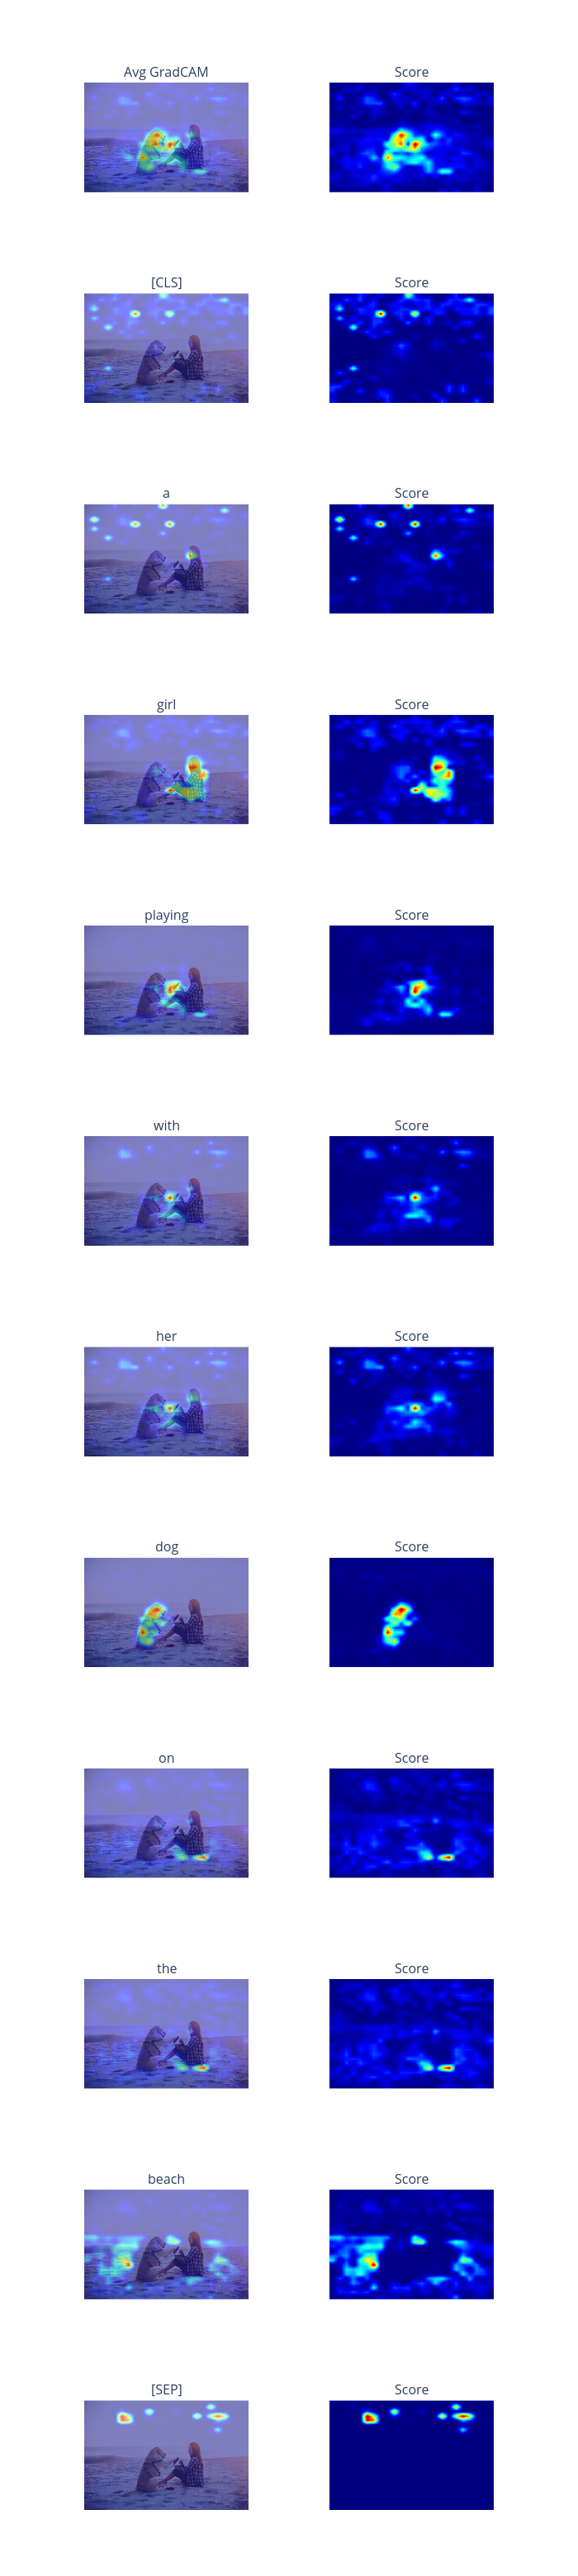

In [7]:
explanations = explainer.explain(inputs)
explanations.ipython_plot()